## Run first cell if in Colab

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/My Drive/cs231n/cs231-project')

Mounted at /content/drive


In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd

from mie2c.e2c import E2C, compute_loss, PWATransition
from mie2c.cartpole_model import (get_cartpole_encoder, get_cartpole_decoder,
    get_cartpole_transition, get_cartpole_linear_transition, get_cartpole_pwa_transition)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# load data generated for the cartpole

X_all = np.load('/content/drive/My Drive/cs231n/cs231-project/data/cartpole_X.npy')
X_next_all = np.load('/content/drive/My Drive/cs231n/cs231-project/data/cartpole_X_next.npy')

In [0]:
# test_ratio = .01
# test_indx = int(test_ratio * X_all.shape[0])
test_indx = 100

X_test = torch.tensor(X_all[:test_indx, :, :, :], dtype=torch.float)
X_next_test = torch.tensor(X_next_all[:test_indx, :, :, :], dtype=torch.float)
X = torch.tensor(X_all[test_indx:, :, :, :], dtype=torch.float)
X_next = torch.tensor(X_next_all[test_indx:, :, :, :], dtype=torch.float)

NUM_TEST = X_test.shape[0]
NUM_DATA = X.shape[0]

In [0]:
del X_all
del X_next_all

In [0]:
def show_samples(X_samples, X_next_samples=None):
    num_samples = X_samples.shape[0]
    fig = plt.figure(figsize=(10,10))
    for k in range(num_samples):
        if X_next_samples is not None:
            fig.add_subplot(num_samples,3,k*3+1)
            plt.imshow(X_samples[k,:3,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
            fig.add_subplot(num_samples,3,k*3+2)
            plt.imshow(X_samples[k,3:,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
            fig.add_subplot(num_samples,3,k*3+3)
            plt.imshow(X_next_samples[k,3:,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
        else:
            fig.add_subplot(num_samples,2,k*2+1)
            plt.imshow(X_samples[k,:3,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
            fig.add_subplot(num_samples,2,k*2+2)
            plt.imshow(X_samples[k,3:,:,:].to('cpu').type(torch.uint8).detach().numpy().transpose(1,2,0))
    plt.show()

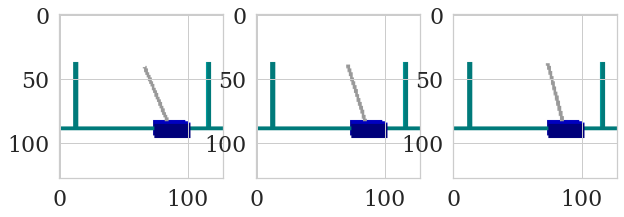

In [8]:
idx = [np.random.randint(NUM_DATA)]
show_samples(X[idx,:,:,:], X_next[idx,:,:,:])

In [0]:
dim_in = X[0].shape
dim_z = 6
dim_u = 0
use_cuda = True

In [0]:
if use_cuda:
    X = X.to('cuda')
    X_next = X_next.to('cuda')
    X_test = X_test.to('cuda')
    X_next_test = X_next_test.to('cuda')

In [0]:
dataset = torch.utils.data.TensorDataset(X, X_next)

# Training method

In [0]:
def train_vae(model, model_name, dataset, verbose=True, cuda=False):
    if not os.path.exists('pytorch'):
        os.makedirs('pytorch')
    fn_pt_model = 'pytorch/{}.pt'.format(model_name)
    dim_u = model.trans.dim_u

    # training parameters
    NUM_EPOCH = 100
    BATCH_SIZE = 64
    CHECKPOINT_AFTER = 10
    SAVEPOINT_AFTER = 20

    KL_LAMBDA = .25
    TEMP_LAMBDA = 10.

    if cuda:
        model = model.to("cuda")

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters())



    itr = 0
    for epoch in range(NUM_EPOCH):
        for x, x_next in dataloader:
            optimizer.zero_grad()

            action = torch.empty(NUM_DATA, dim_u)

            model(x, action, x_next)
            elbo_loss, kl_loss = compute_loss(model.x_dec, model.x_next_dec, model.x_next_pred_dec,
                                              x, x_next,
                                              model.Qz, model.Qz_next, model.Qz_next_pred)
            loss = elbo_loss + KL_LAMBDA * kl_loss
            if isinstance(model.trans, PWATransition):
                loss += TEMP_LAMBDA * model.trans.temperature.pow(2)[0]

            loss.backward()
            optimizer.step()

            if itr % CHECKPOINT_AFTER == 0:
                print('Avg. loss: {}'.format(loss.item()))

            if itr % SAVEPOINT_AFTER == 0:
                torch.save(model.state_dict(), fn_pt_model)

            itr += 1

    torch.save(model.state_dict(), fn_pt_model)

# E2C Transition

In [0]:
encoder = get_cartpole_encoder(dim_in, dim_z)
e2c_transition = get_cartpole_transition(dim_z, dim_u)
decoder = get_cartpole_decoder(dim_z, dim_in)

fn_e2c = 'model_e2c'
model_e2c = E2C(encoder, e2c_transition, decoder)

# if os.path.exists('pytorch/{}.pt'.format(fn_e2c)):
#     model_e2c.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_e2c)))

In [14]:
train_vae(model_e2c, fn_e2c, dataset, verbose=True, cuda=use_cuda)

Avg. loss: 5993095272.382119
Avg. loss: 180095686.29586083
Avg. loss: 145116860.75398257
Avg. loss: 111084274.8991028
Avg. loss: 80593627.28958587
Avg. loss: 70145387.03415683
Avg. loss: 68294864.48267145
Avg. loss: 59082309.90402795
Avg. loss: 58342805.68361277
Avg. loss: 56596839.08212147
Avg. loss: 73661601.38340127
Avg. loss: 50078963.019346
Avg. loss: 46521016.53735621
Avg. loss: 59831421.1331022
Avg. loss: 44352627.73725178
Avg. loss: 20940531.37991823
Avg. loss: 18198235.264645882
Avg. loss: 16659884.64929376
Avg. loss: 16869957.0321511
Avg. loss: 15872182.485258292
Avg. loss: 15584683.5088121
Avg. loss: 17254476.662275985
Avg. loss: 13329508.92964496
Avg. loss: 13328722.62785539
Avg. loss: 14359834.583717901
Avg. loss: 12366176.135181444
Avg. loss: 13372883.250491
Avg. loss: 12460255.502946386
Avg. loss: 13441203.523840716
Avg. loss: 13329446.810007114
Avg. loss: 14440051.78165723
Avg. loss: 10366528.083072703
Avg. loss: 11407557.389017412
Avg. loss: 10295201.604810303
Avg. los

KeyboardInterrupt: ignored

In [0]:
x_pred_e2c = model_e2c.predict(X_test, torch.empty(NUM_TEST,1).float())

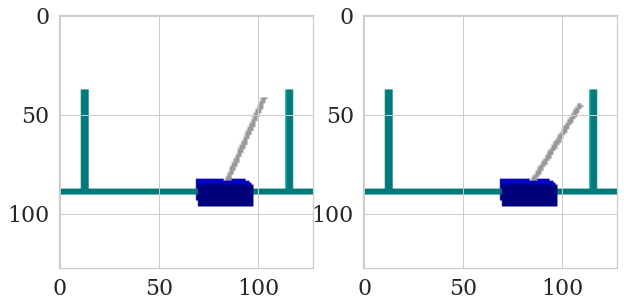

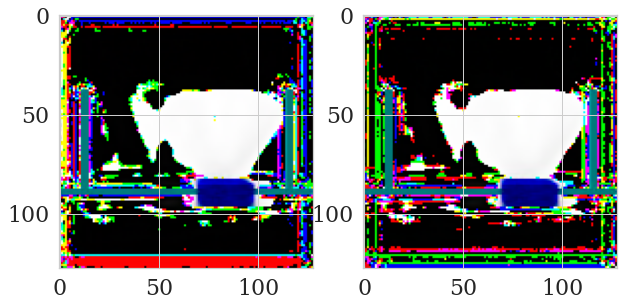

In [20]:
idx = [np.random.randint(NUM_TEST)]
show_samples(X_test[idx,:,:,:])
show_samples(x_pred_e2c[idx,:,:,:])

# Linear Transition

In [0]:
use_low_rank = True  # True if A = I + r*v^T

encoder = get_cartpole_encoder(dim_in, dim_z)
lin_transition = get_cartpole_linear_transition(dim_z, dim_u, low_rank=use_low_rank)
decoder = get_cartpole_decoder(dim_z, dim_in) 

fn_lin = 'model_lin'
model_lin = E2C(encoder, lin_transition, decoder)

# if os.path.exists('pytorch/{}.pt'.format(fn_lin)):
#     model_lin.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_lin)))

In [31]:
train_vae(model_lin, fn_lin, dataset, verbose=True, cuda=use_cuda)

RuntimeError: ignored

In [0]:
x_pred_lin = model_lin.predict(X_test, torch.empty(NUM_TEST,1).float())

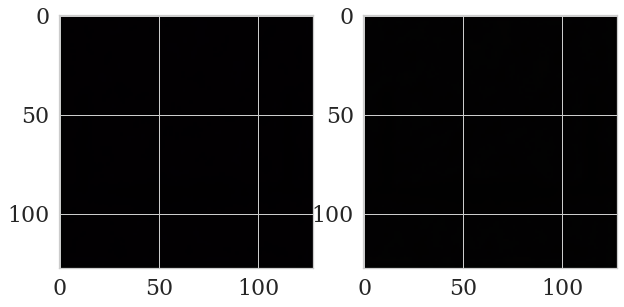

In [54]:
idx = [np.random.randint(NUM_TEST)]
show_samples(X_test[idx,:,:,:])
show_samples(x_pred_lin[idx,:,:,:])

# PWA Transition

In [0]:
use_low_rank = False  # True if A = I + r*v^T
num_modes = 3

encoder = get_cartpole_encoder(dim_in, dim_z)
pwa_transition = get_cartpole_pwa_transition(num_modes, dim_z, dim_u, low_rank=use_low_rank)
decoder = get_cartpole_decoder(dim_z, dim_in) 

fn_pwa = 'model_pwa'
model_pwa = E2C(encoder, pwa_transition, decoder)

# if os.path.exists('pytorch/{}.pt'.format(fn_pwa)):
#     model_pwa.load_state_dict(torch.load('pytorch/{}.pt'.format(fn_pwa)))

In [14]:
train_vae(model_pwa, fn_pwa, dataset, verbose=True, cuda=use_cuda)

Avg. loss: 5992586487.681323
Avg. loss: 5780924550.436011
Avg. loss: 3149021328.0961404
Avg. loss: 4429926562.838644
Avg. loss: 2498339650.7887077
Avg. loss: 2248320121.649806
Avg. loss: 1471778755.142555
Avg. loss: 1121442750.1435802
Avg. loss: 492772740.1444071
Avg. loss: 268294215.41307306
Avg. loss: 217176393.71676308
Avg. loss: 231486296.71357462
Avg. loss: 202145451.23321378
Avg. loss: 184517037.85194623
Avg. loss: 170434313.4060624
Avg. loss: 164894682.80521625
Avg. loss: 159312539.38821128
Avg. loss: 156053844.07499054
Avg. loss: 151874273.13509732
Avg. loss: 150486909.06066838
Avg. loss: 145645550.47543013
Avg. loss: 146478735.68966332
Avg. loss: 139654187.77923903
Avg. loss: 140204827.75952825
Avg. loss: 134269866.9485584
Avg. loss: 133296567.03911789
Avg. loss: 126030789.57380944
Avg. loss: 124383761.94756308
Avg. loss: 119586176.07755345
Avg. loss: 116869348.88544808
Avg. loss: 110172258.62716047
Avg. loss: 104010915.73448962
Avg. loss: 108408349.93565468
Avg. loss: 9974538

KeyboardInterrupt: ignored

In [0]:
x_pred_pwa = model_pwa.predict(X_test, torch.empty(NUM_TEST,1).float())

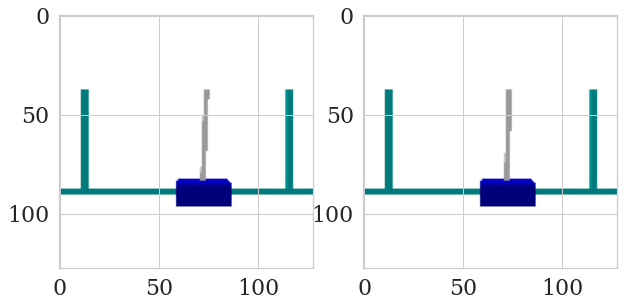

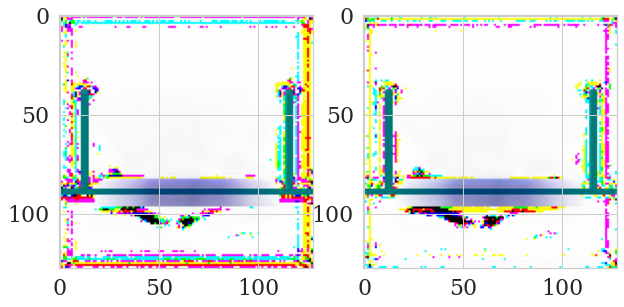

In [20]:
idx = [np.random.randint(NUM_TEST)]
show_samples(X_test[idx,:,:,:])
show_samples(x_pred_pwa[idx,:,:,:])

# Evaluation

In [60]:
l2_err_e2c = (x_pred_e2c - X_test).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()
l2_err_lin = (x_pred_lin - X_test).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()
l2_err_pwa = (x_pred_pwa - X_test).pow(2).sum(axis=1).sum(axis=1).sum(axis=1).pow(0.5).detach().cpu().numpy()

print("e2c: " + str(l2_err_e2c.mean()))
print("linear: " + str(l2_err_lin.mean()))
print("pwa: " + str(l2_err_pwa.mean()))

e2c: 444359.25
linear: 76829.4
pwa: 58099.83


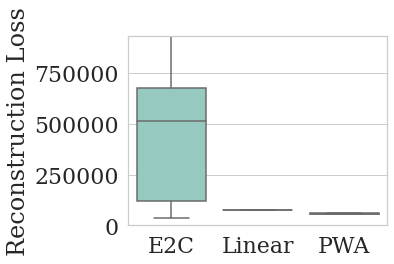

In [61]:
results = {'E2C':l2_err_e2c, 'Linear':l2_err_lin, 'PWA':l2_err_pwa}
results = pd.DataFrame(results)

ax1 = sns.boxplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Reconstruction Loss")

plt.tight_layout()
plt.ylim(0, int(math.ceil(np.max(np.maximum(l2_err_lin, l2_err_e2c, l2_err_pwa)) / 10.0)) * 10)

figure = ax1.get_figure()
figure.savefig("loss.pdf")